# Read and combine data from all plates<br>
## and<br>
# QC

In [1]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import warnings
import config as general_paths
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
# Filtering parameters

HOW_MANY_HIGHLY_VARIABLE_GENES = 16000 # it used to be 15000 (but that cuts out Piezo1 after filtering out not highly variable genes)
MIN_CELL_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS_WITH_GENE = 5
MITOCHONDRIAL_THRESHOLD_PCT = 5

# possible number of PCA
PCA_NO = 20

In [3]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path

Output h5ad files for later analysis

In [4]:
# file with not normalized not highly variable genes
campari_raw_file_all_genes = 'campari_raw_all_genes_from_kallisto.h5ad'
# file with highly variable genes, log normalizes, regressed and scaled
campari_file = 'campari_from_kallisto.h5ad'
campari_no_doublets_file = 'campari_from_kallisto_no_doublets.h5ad'

## Read and merge all data

In [5]:
# load the unfiltered matrix and define all paths for storing data

results_file_sample1 = os.path.join(local_path,'sample1/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample2 = os.path.join(local_path,'sample2/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample3 = os.path.join(local_path,'sample3/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample4 = os.path.join(local_path,'sample4/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample5 = os.path.join(local_path,'sample5/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample6 = os.path.join(local_path,'sample6/counts_unfiltered_umi/adata.h5ad') 
results_file_sample7 = os.path.join(local_path,'sample7/counts_unfiltered_umi/adata.h5ad')
#txt file with kept cells
cell_barcode_file_sample1 = os.path.join(local_path,'sample1/counts_umiR/SS3_22_291kept_barcodes.txt')
cell_barcode_file_sample2 = os.path.join(local_path,'sample2/counts_umiR/SS3_23_049kept_barcodes.txt')
cell_barcode_file_sample3 = os.path.join(local_path,'sample3/counts_umiR/SS3_23_127kept_barcodes.txt')
cell_barcode_file_sample4 = os.path.join(local_path,'sample4/counts_umiR/SS3_23_193kept_barcodes.txt')
cell_barcode_file_sample5 = os.path.join(local_path,'sample5/counts_umiR/SS3_23_195kept_barcodes.txt')
cell_barcode_file_sample6 = os.path.join(local_path,'sample6/counts_umiR/SS3_23_325kept_barcodes.txt')
cell_barcode_file_sample7= os.path.join(local_path,'sample7/counts_umiR/SS3_23_327kept_barcodes.txt')
#read barcodes with kalisto
cell_barcode_file_new_sample1 = os.path.join(local_path,'sample1/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample2 = os.path.join(local_path,'sample2/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample3 = os.path.join(local_path,'sample3/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample4 = os.path.join(local_path,'sample4/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample5 = os.path.join(local_path,'sample5/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample6 = os.path.join(local_path,'sample6/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample7 = os.path.join(local_path,'sample7/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
#txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = os.path.join(local_path,'sample1/counts_umiR/SS3_22_291.well_barcodes.txt')
well_barcode_sample2 = os.path.join(local_path,'sample2/counts_umiR/SS3_23_049.well_barcodes.txt')
well_barcode_sample3 = os.path.join(local_path,'sample3/counts_umiR/SS3_23_127.well_barcodes.txt')
well_barcode_sample4 = os.path.join(local_path,'sample4/counts_umiR/SS3_23_193.well_barcodes.txt')
well_barcode_sample5 = os.path.join(local_path,'sample5/counts_umiR/SS3_23_195.well_barcodes.txt')
well_barcode_sample6 = os.path.join(local_path,'sample6/counts_umiR/SS3_23_325.well_barcodes.txt')
well_barcode_sample7 = os.path.join(local_path,'sample7/counts_umiR/SS3_23_327.well_barcodes.txt')
###upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path =os.path.join(local_path,'sample1/counts_umiR/well_1_data_base.csv')
florecence_2_file_path = os.path.join(local_path,'sample2/counts_umiR/well_2_data_base.csv')
florecence_3_file_path = os.path.join(local_path,'sample3/counts_umiR/well_3_data_base.csv')
florecence_4_file_path = os.path.join(local_path,'sample4/counts_umiR/well_4_data_base.csv')
florecence_5_file_path = os.path.join(local_path,'sample5/counts_umiR/well_5_data_base.csv')
florecence_6_file_path = os.path.join(local_path,'sample6/counts_umiR/well_6_data_base.csv')
florecence_7_file_path = os.path.join(local_path,'sample7/counts_umiR/well_7_data_base.csv')

In [6]:
### load raw adata file using adata libraty
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)
sample4 = ad.read_h5ad(results_file_sample4)
sample5 = ad.read_h5ad(results_file_sample5)
sample6 = ad.read_h5ad(results_file_sample6)
sample7 = ad.read_h5ad(results_file_sample7)
### read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)
flourecence6 = pd.read_csv(florecence_6_file_path)
flourecence7 = pd.read_csv(florecence_7_file_path)
### read kept barcodes and barcodes provided by kalisto
df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
df_2_sample1 = pd.read_csv(cell_barcode_file_new_sample1)

df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
df_2_sample2 = pd.read_csv(cell_barcode_file_new_sample2)

df_1_sample3 = pd.read_csv(cell_barcode_file_sample3, delimiter = "\,")
df_2_sample3 = pd.read_csv(cell_barcode_file_new_sample3)

df_1_sample4 = pd.read_csv(cell_barcode_file_sample4, delimiter = "\,")
df_2_sample4 = pd.read_csv(cell_barcode_file_new_sample4)

df_1_sample5 = pd.read_csv(cell_barcode_file_sample5, delimiter = "\,")
df_2_sample5 = pd.read_csv(cell_barcode_file_new_sample5)

df_1_sample6 = pd.read_csv(cell_barcode_file_sample6, delimiter = "\,")
df_2_sample6 = pd.read_csv(cell_barcode_file_new_sample6)

df_1_sample7 = pd.read_csv(cell_barcode_file_sample7, delimiter = "\,")
df_2_sample7 = pd.read_csv(cell_barcode_file_new_sample7)


In [7]:
### merge data base. Merge information about cell barcode and fluorecence 
### (using as common demonimator the position in the plate)
barcode_list_sample1 = list(df_1_sample1['XC'])
well_df_sample1 = pd.read_csv(well_barcode_sample1, sep = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, sep = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, sep = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

barcode_list_sample4 = list(df_1_sample4['XC'])
well_df_sample4 = pd.read_csv(well_barcode_sample4, sep = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

barcode_list_sample5 = list(df_1_sample5['XC'])
well_df_sample5 = pd.read_csv(well_barcode_sample5, sep = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

barcode_list_sample6 = list(df_1_sample6['XC'])
well_df_sample6 = pd.read_csv(well_barcode_sample6, sep = "\t")
mergedRes6 = pd.merge(well_df_sample6 , flourecence6, on ='well_id')

barcode_list_sample7 = list(df_1_sample7['XC'])
well_df_sample7 = pd.read_csv(well_barcode_sample7, sep = "\t")
mergedRes7 = pd.merge(well_df_sample7 , flourecence7, on ='well_id')

In [8]:
# add some metadata
sample1.obs['sample']="Sample_1"
sample2.obs['sample']="Sample_2"
sample3.obs['sample']="Sample_3"
sample4.obs['sample']="Sample_4"
sample5.obs['sample']="Sample_5"
sample6.obs['sample']="Sample_6"
sample7.obs['sample']="Sample_7"

In [9]:
sample7

AnnData object with n_obs × n_vars = 1022 × 34183
    obs: 'sample'

In [10]:
# check kept barcodes with barcodes from kallisto, and create ordered lists of well ids, stimuli, fluorecsense and plate number
def barcode_check(df_1,df_2,barcode_list,mergedRes):

    #print(barcode_list)
    kept_cells = np.zeros((len(df_1),))
    well_id = well_id = ["NA" for el in barcode_list] # these are strings (i.e "A1")

    red_f = np.zeros((len(df_1),))
    green_f = np.zeros((len(df_1),))
    stimulus = np.zeros((len(df_1),))
    plate_number = np.zeros((len(barcode_list),))

    index_vector = np.zeros((len(df_1),))
    count = 0
    counter = 0
    for i in range(len(df_2)):
        x = df_2.iloc[i]['Barcodes']
        if x in barcode_list:
            index = barcode_list.index(x)
            index_vector[count] = index
            if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
                counter+=1
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                plate_number[index] = mergedRes['well_number'].where(mergedRes['bc_set'] == x)[position]
                kept_cells[index] = int(i)
                well_id[index] = mergedRes['well_id'].where(mergedRes['bc_set'] == x)[position]
                count +=1
    #kept_cells = np.unique(kept_cells)
    count = len(df_1)
    # replace all nans to zeros
    np.nan_to_num(well_id,copy=False)
    np.nan_to_num(stimulus,copy=False)
    np.nan_to_num(red_f,copy=False)
    np.nan_to_num(green_f,copy=False)
    np.nan_to_num(plate_number,copy=False)
    
    return kept_cells, well_id,stimulus,red_f,green_f, plate_number

In [11]:
kept_cells1, well_id1,stimulus_1,red_f1,green_f1, plate_number1 = barcode_check(df_1_sample1,df_2_sample1,barcode_list_sample1,mergedRes1)
kept_cells2, well_id2,stimulus_2,red_f2,green_f2, plate_number2 = barcode_check(df_1_sample2,df_2_sample2,barcode_list_sample2,mergedRes2)
kept_cells3, well_id3,stimulus_3,red_f3,green_f3, plate_number3 = barcode_check(df_1_sample3,df_2_sample3,barcode_list_sample3,mergedRes3)
kept_cells4, well_id4,stimulus_4,red_f4,green_f4, plate_number4 = barcode_check(df_1_sample4,df_2_sample4,barcode_list_sample4,mergedRes4)
kept_cells5, well_id5,stimulus_5,red_f5,green_f5, plate_number5 = barcode_check(df_1_sample5,df_2_sample5,barcode_list_sample5,mergedRes5)
kept_cells6, well_id6,stimulus_6,red_f6,green_f6, plate_number6  = barcode_check(df_1_sample6,df_2_sample6,barcode_list_sample6,mergedRes6)
kept_cells7, well_id7,stimulus_7,red_f7,green_f7, plate_number7  = barcode_check(df_1_sample7,df_2_sample7,barcode_list_sample7,mergedRes7)

In [12]:

sample1.var_names_make_unique() 
sample2.var_names_make_unique() 
sample3.var_names_make_unique() 
sample4.var_names_make_unique() 
sample5.var_names_make_unique() 
sample6.var_names_make_unique() 
sample7.var_names_make_unique() 

In [13]:
### select only kept cells
adata1 = sample1[kept_cells1.astype(int),:]
adata2 = sample2[kept_cells2.astype(int),:]
adata3 = sample3[kept_cells3.astype(int),:]
adata4 = sample4[kept_cells4.astype(int),:]
adata5 = sample5[kept_cells5.astype(int),:]
adata6 = sample6[kept_cells6.astype(int),:]
adata7 = sample7[kept_cells7.astype(int),:]
### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1
adata1.obs['plate_number'] = plate_number1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2
adata2.obs['plate_number'] = plate_number2

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3
adata3.obs['plate_number'] = plate_number3

adata4.obs['stimulus'] = stimulus_4
adata4.obs['red'] = red_f4
adata4.obs['green'] = green_f4
adata4.obs['well_id'] = well_id4
adata4.obs['plate_number'] = plate_number4


adata5.obs['stimulus'] = stimulus_5
adata5.obs['red'] = red_f5
adata5.obs['green'] = green_f5
adata5.obs['well_id'] = well_id5
adata5.obs['plate_number'] = plate_number5

adata6.obs['stimulus'] = stimulus_6
adata6.obs['red'] = red_f6
adata6.obs['green'] = green_f6
adata6.obs['well_id'] = well_id6
adata6.obs['plate_number'] = plate_number6


adata7.obs['stimulus'] = stimulus_7
adata7.obs['red'] = red_f7
adata7.obs['green'] = green_f7
adata7.obs['well_id'] = well_id7
adata7.obs['plate_number'] = plate_number7

## Merge all plates data into a single adata object

In [14]:
### data integration
adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_2 = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata_3 = adata_2.concatenate(adata4, join='outer', batch_categories=['sample123', 'sample4'], index_unique='-')
adata_4 = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')
adata_5 = adata_4.concatenate(adata6, join='outer', batch_categories=['sample12345', 'sample6'], index_unique='-')

adata = adata_5.concatenate(adata7, join='outer', batch_categories=['sample123456', 'sample7'], index_unique='-')


adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Number of cells:', adata.X.shape[0]) # len(adata.obs_names)
print('Number of genes:', adata.X.shape[1]) # len(adata.var_names)

Number of cells: 2688
Number of genes: 34183


In [15]:
adata.var_names_make_unique() 
print('Number of cells:', adata.X.shape[0])
print('Number of genes:', adata.X.shape[1])

Number of cells: 2688
Number of genes: 34183


In [16]:
# how many cells in each sample
print(adata.obs['sample'].value_counts()) 
adata

Sample_1    384
Sample_2    384
Sample_3    384
Sample_4    384
Sample_5    384
Sample_6    384
Sample_7    384
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 2688 × 34183
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch'

## Add gene names information from t2g file downloaded from kallisto

In [17]:
t2g = pd.read_csv("t2g.txt", header=None,  names=["tid", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")
t2g.index = t2g.gene_id### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)
print(len(t2g))
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]
print(len(t2g))

126126
34183


In [18]:
t2g

,tid,gene_id,gene_name,gene_variant,num1,num2,num3,pos_neg
gene_id,,,,,,,,
ENSMUSG00000086053.2,ENSMUST00000132100.2,ENSMUSG00000086053.2,Gm15178,Gm15178-201,1,75368775,75373007,-
ENSMUSG00000100764.2,ENSMUST00000185910.2,ENSMUSG00000100764.2,Gm29155,Gm29155-201,1,43782744,43783012,-
ENSMUSG00000102095.2,ENSMUST00000188305.2,ENSMUSG00000102095.2,C730036E19Rik,C730036E19Rik-201,1,151013785,151018096,+
ENSMUSG00000100635.2,ENSMUST00000188753.2,ENSMUSG00000100635.2,Gm29157,Gm29157-201,1,43782075,43782686,+
ENSMUSG00000100480.2,ENSMUST00000187764.2,ENSMUSG00000100480.2,Gm29156,Gm29156-201,1,43784944,43785442,-
...,...,...,...,...,...,...,...,...
ENSMUSG00000095019.2,ENSMUST00000178569.2,ENSMUSG00000095019.2,NaN,NaN,JH584303.1,81607,82689,+
ENSMUSG00000094915.2,ENSMUST00000179715.2,ENSMUSG00000094915.2,NaN,NaN,GL456212.1,31967,34932,-
ENSMUSG00000079808.4,ENSMUST00000115924.3,ENSMUSG00000079808.4,NaN,NaN,GL456212.1,128555,150452,-


In [19]:
adata.var["gene_id"] = adata.var.index.values
adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])

In [20]:
adata.var["gene_name"]

gene_id
ENSMUSG00000086053.2          Gm15178
ENSMUSG00000100764.2          Gm29155
ENSMUSG00000102095.2    C730036E19Rik
ENSMUSG00000100635.2          Gm29157
ENSMUSG00000100480.2          Gm29156
                            ...      
ENSMUSG00000095019.2              NaN
ENSMUSG00000094915.2              NaN
ENSMUSG00000079808.4              NaN
ENSMUSG00000095041.8              NaN
ENSMUSG00000095742.2              NaN
Name: gene_name, Length: 34183, dtype: object

In [21]:
# Some of the gene ids don't have gene names in the t2g file from kallisto
# replace those missing gene names with their ids
def replace_nan_gene_names_with_gene_id(adata_object):
    ctr = 0
    fixed_gene_names = []
    for i, gene in enumerate(adata_object.var["gene_name"].values):
        gene_name = gene
        if gene is np.nan:
            ctr +=1
            gene_name = adata_object.var["gene_id"].values[i]
        fixed_gene_names.append(gene_name)
    print(f"{ctr} missing gene names")
    # replace the list of gene ids with nans with a list of gene names or gene ids
    adata_object.var["gene_name"] = fixed_gene_names
    return adata_object

In [22]:
# replace missing gene names with their ids
adata = replace_nan_gene_names_with_gene_id(adata)
adata.var.index = adata.var["gene_name"]

1523 missing gene names


In [23]:
adata.var["gene_name"].values

array(['Gm15178', 'Gm29155', 'C730036E19Rik', ..., 'ENSMUSG00000079808.4',
       'ENSMUSG00000095041.8', 'ENSMUSG00000095742.2'], dtype=object)

In [24]:
# make names unique
adata.var_names_make_unique()
'Piezo1' in adata.var['gene_name'] # check if Piezo1 is still there

True

## Add stimulus names<br>
* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: vaginal distansion
* 12: tomatoe
* 13: poop
* 14: Bladder
* 15: Colon-rectum distension (CRD)
* 16: AD + CFA (anal distension + inflamation)
* 17: AGB + CFA (ano-genital brush + inflamation)
* 18: Heating + CFA (heating + inflamation)
* 19: Tail Brush
* 20: TRPM8 td Tomato
* 21: AD + Pulse
* 22: AGB-CFA 1 W
* 23: AD-CFA 1W
* 24: HP
* 25: Penis
* 26: Clitoris Vibration
* 27: Max Cells
* 28: Tracing Ano Genital Skin injection
* 29: Crazy Mock
* 30: Tracing Anal injection
* 31: Tracing Vagina

In [25]:
labels=['Control','Pinch','New_stroke','Ballon','AG','AD','Heating','Mock','Old_stroke','Anal_pinch','Mock_w_poop','Vaginal_distension','Tomato','Poop', 
        'Bladder','CRD','AD+CFA','AGB+CFA','Heating+CFA','Tail Brush','TRPM8 td tomato',
        'AD + Pulse', 'AGB+CFA 1 W','AD+CFA 1W','HP','Penis','Clitoris Vibration','Max Cells',
        'Tracing Ano Genital Skin injection','Crazy Mock','Tracing Anal injection', 'Tracing Vagina']
stim_str = ['0', '1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']

In [26]:
# create category type obs variable that will be used for ranking
adata.obs['stimulus_name'] = adata.obs['stimulus'].astype('category') # copy stimulus data to new obs for ranking 
new_values = [str(int(el)) for el in adata.obs['stimulus_name'].values]    # convert stimulus to string categories
adata.obs['stimulus_name'] = new_values                                    # replace float values with new string values (changed type to object)
adata.obs['stimulus_name'].astype('category')                              # make it category type again

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    2
                                                                                      ..
CGGTTGAACGGAGCGGAACT-sample7                                                           4
AAAGTGACAAACCTCACCAG-sample7                                                           0
AAAGTGACAAACCTCACCAG-sample7                                                           0
AAAGTGACAAACCTCACCAG-sample7                                                           0
AAAGTGACAAACCTCACCAG-sample7                                                           0
Name: stimulu

In [27]:
# create ordered list of stim names
stim_labels = []
for stim in adata.obs['stimulus_name'].values:
    idx = stim_str.index(stim)
    new_label = labels[idx]
    stim_labels.append(new_label)

In [28]:
adata.obs['stimulus_name'] = stim_labels 
adata.obs['stimulus_name']

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456         Pinch
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456         Pinch
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456         Pinch
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456         Pinch
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    New_stroke
                                                                                          ...    
CGGTTGAACGGAGCGGAACT-sample7                                                                   AG
AAAGTGACAAACCTCACCAG-sample7                                                              Control
AAAGTGACAAACCTCACCAG-sample7                                                              Control
AAAGTGACAAACCTCACCAG-sample7                                                              Control
AAAGTGACAAAC

In [29]:
# make names unique
adata.var_names_make_unique()

## QC

normalizing counts per cell


    finished (0:00:00)


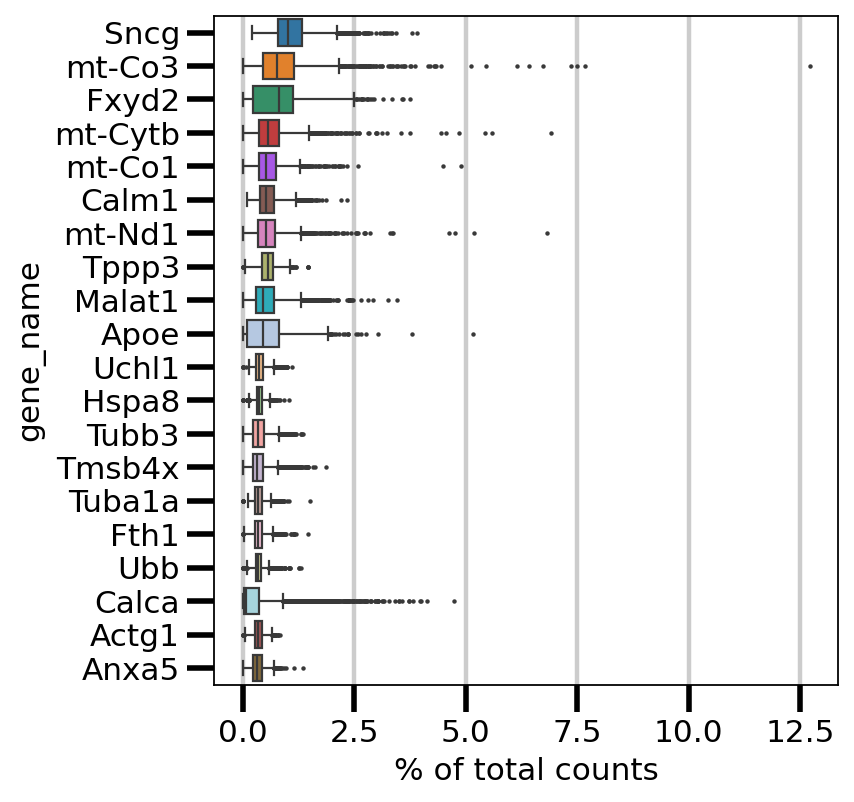

In [30]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [31]:
# count mitochondrial genes
cnt = 0
for gene in adata.var["gene_name"].values:
    if gene.startswith('mt-'):
        cnt+=1
print(f"total mitochondrial: {cnt}")

total mitochondrial: 13


In [32]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

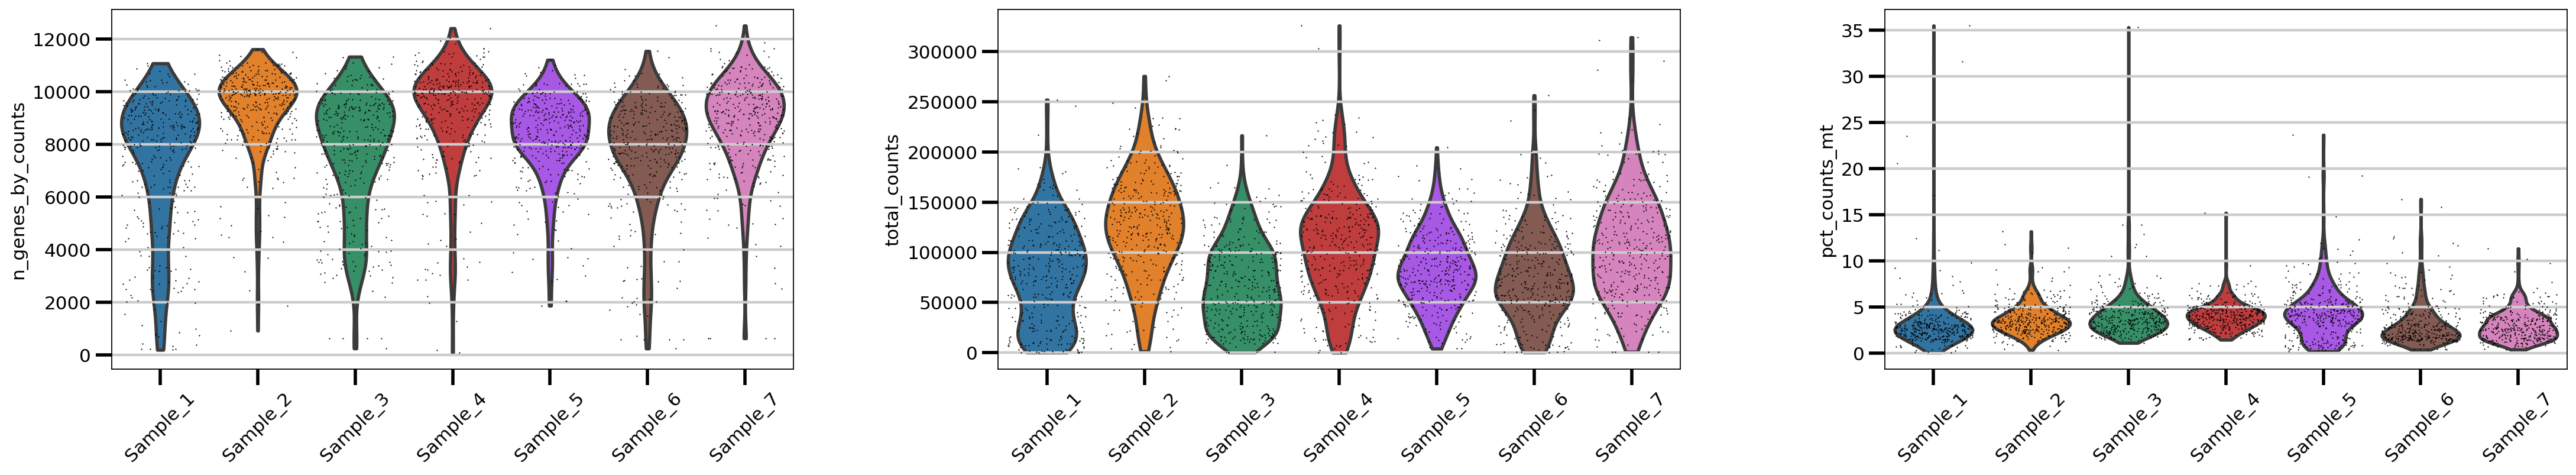

In [33]:
rcParams['figure.figsize']=(8,5)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, groupby = 'sample', rotation= 45)

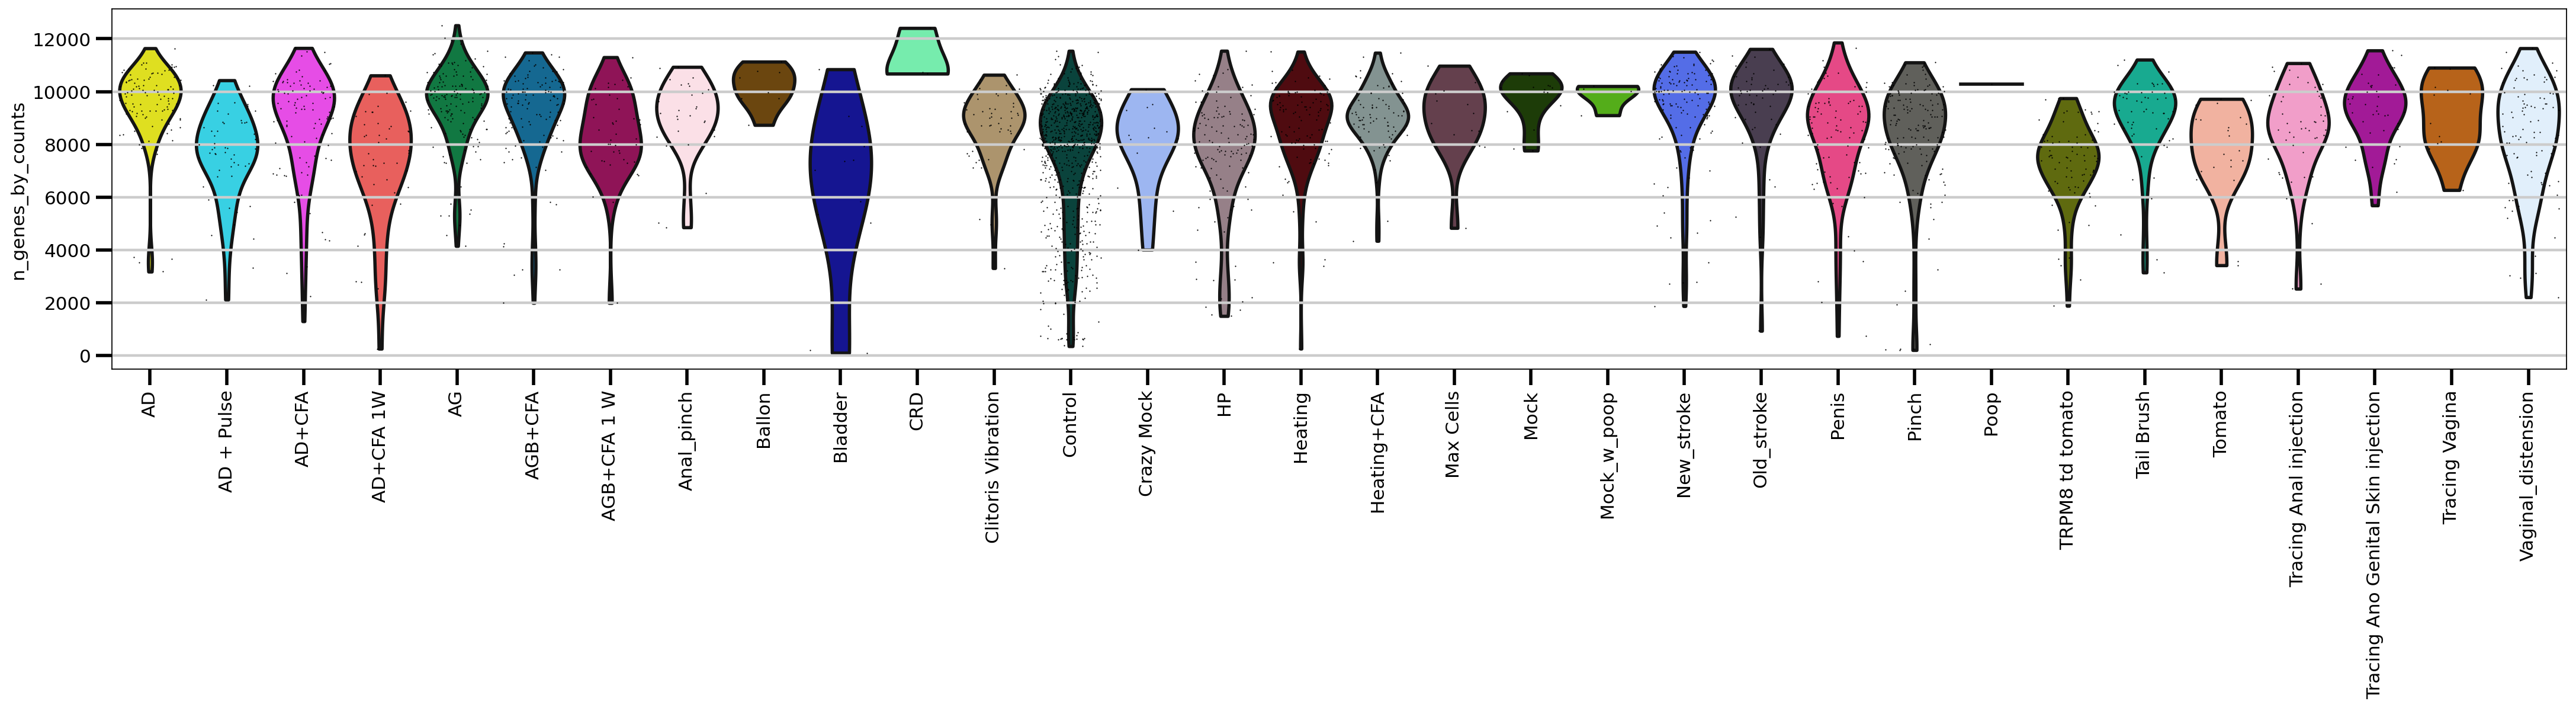

In [34]:
rcParams['figure.figsize']=(25,5)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'stimulus_name', rotation= 90)

In [35]:
# check how many of cells each stimulus has
my_stimuli = np.unique(adata.obs['stimulus_name'].values)
for stim in (my_stimuli):
    single_stim_data = adata[adata.obs['stimulus_name'] == stim]
    total_cells = len(single_stim_data.obs['stimulus_name'].values)
    print(f"{stim}: {total_cells} cells")

AD: 107 cells
AD + Pulse: 55 cells
AD+CFA: 99 cells
AD+CFA 1W: 47 cells
AG: 148 cells
AGB+CFA: 120 cells
AGB+CFA 1 W: 46 cells
Anal_pinch: 32 cells
Ballon: 8 cells
Bladder: 12 cells
CRD: 3 cells
Clitoris Vibration: 51 cells
Control: 788 cells
Crazy Mock: 14 cells
HP: 132 cells
Heating: 105 cells
Heating+CFA: 85 cells
Max Cells: 16 cells
Mock: 16 cells
Mock_w_poop: 4 cells
New_stroke: 133 cells
Old_stroke: 56 cells
Penis: 94 cells
Pinch: 159 cells
Poop: 1 cells
TRPM8 td tomato: 81 cells
Tail Brush: 56 cells
Tomato: 22 cells
Tracing Anal injection: 51 cells
Tracing Ano Genital Skin injection: 40 cells
Tracing Vagina: 12 cells
Vaginal_distension: 95 cells


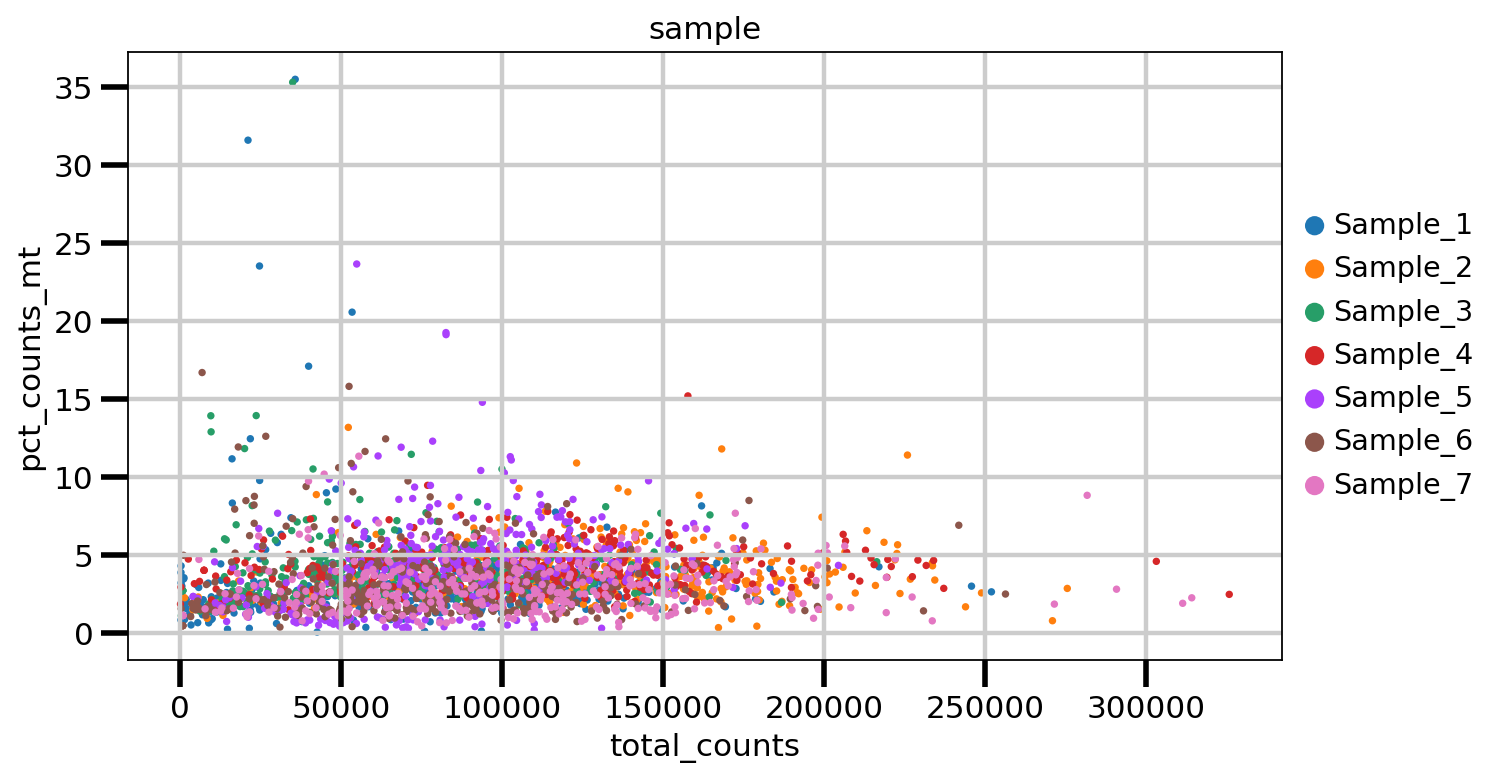

In [36]:
rcParams['figure.figsize']=(8,5)
# show on scatter plot
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

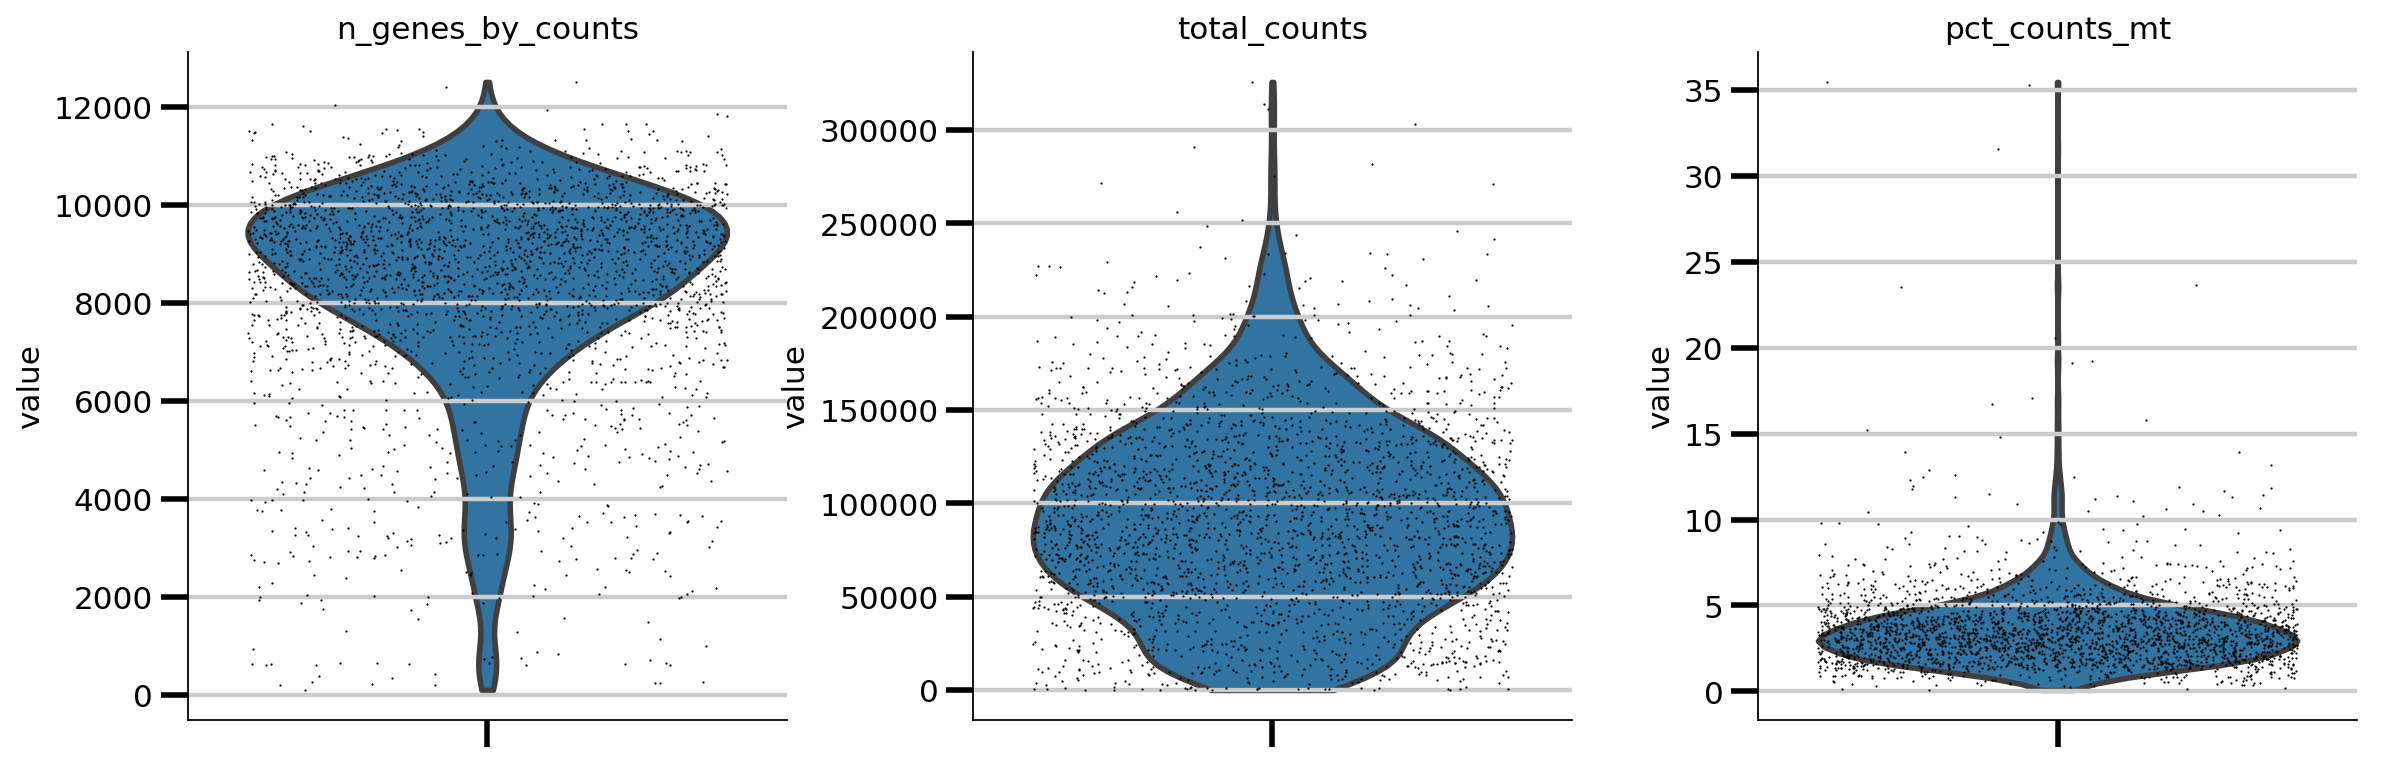

In [37]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Filtering

In [38]:

print('Number of cells before removing some mitochondrial: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
# Do the filtering by slicing the AnnData object
adata = adata[adata.obs.pct_counts_mt < MITOCHONDRIAL_THRESHOLD_PCT, :]
print('Number of cells after removing some mitochondrial: {:d}'.format(adata.n_obs))

Number of cells before removing some mitochondrial: 2688
Number of cells after removing some mitochondrial: 2230


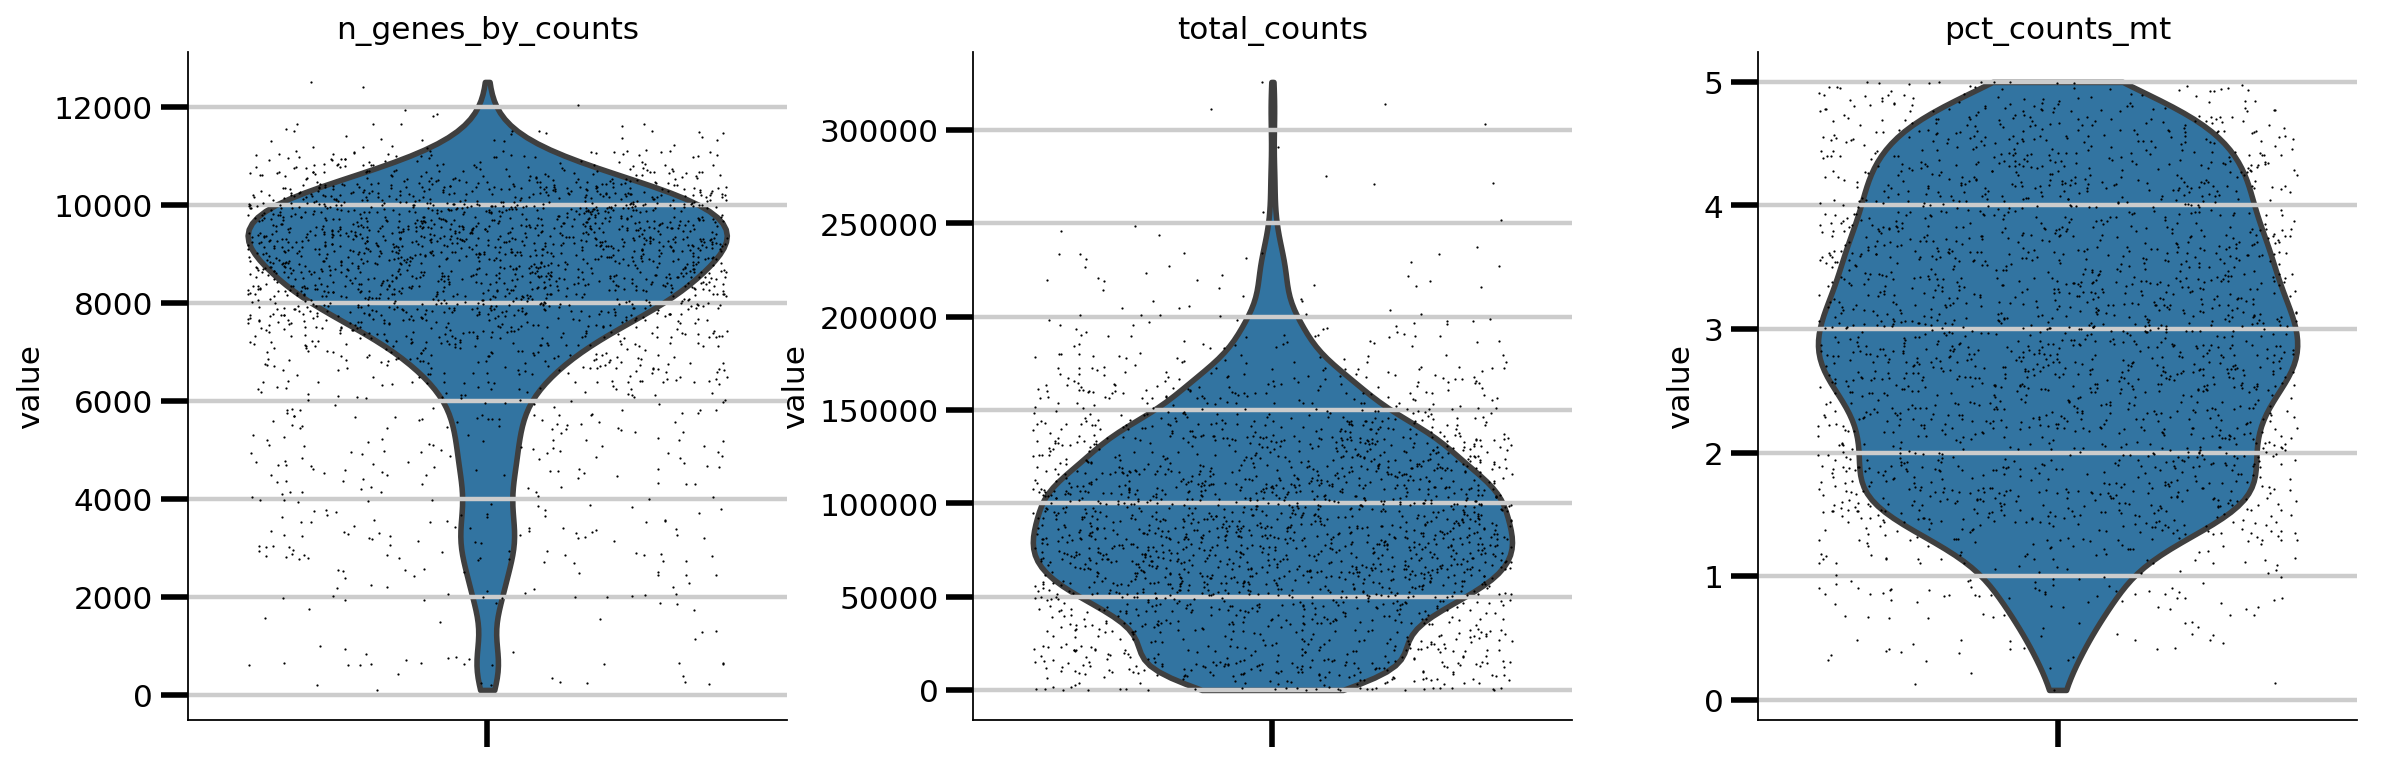

In [39]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

normalizing counts per cell
    finished (0:00:00)


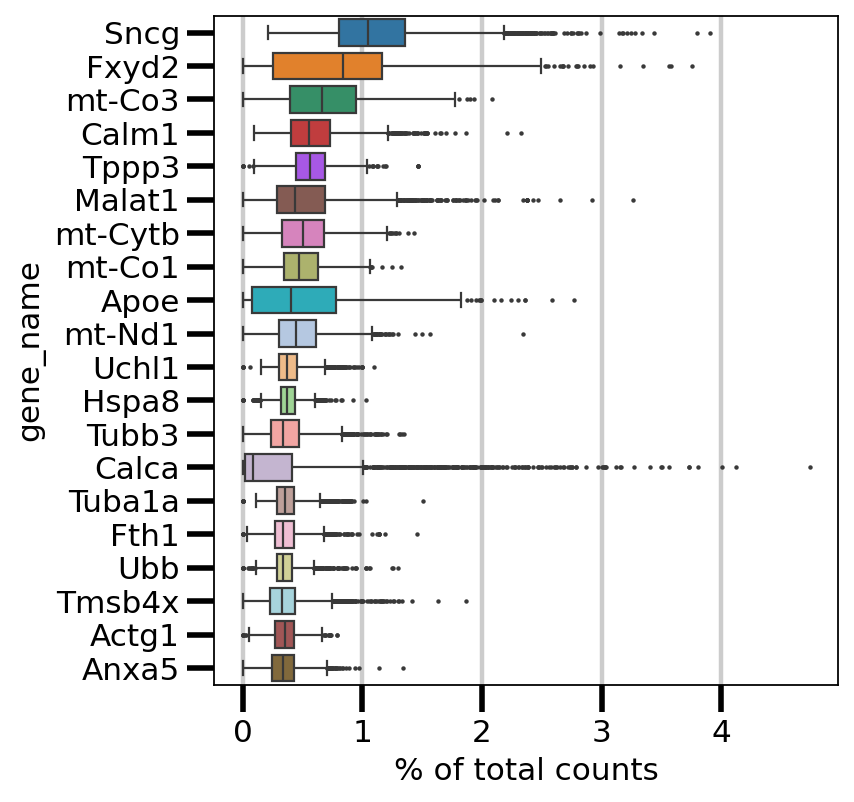

In [40]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [41]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = MIN_CELL_COUNTS)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Total number of cells before: 2230
filtered out 96 cells that have less than 10000 counts


Total number of cells after: 2134


In [42]:
print('Number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = MIN_GENES)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 2134
filtered out 8 cells that have less than 3000 genes expressed
Total number of cells after: 2126


In [43]:
print('Number of genes before: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_WITH_GENE)
print('Number of genes after: {:d}'.format(adata.n_vars))

Number of genes before: 34183
filtered out 12419 genes that are detected in less than 5 cells
Number of genes after: 21764


Export raw values after basic filtering

In [44]:
# save all genes before filtering highly variable and before normalization
adata.write_h5ad(
    os.path.join(output_path, campari_raw_file_all_genes)
)
adata

AnnData object with n_obs × n_vars = 2126 × 21764
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'sample_colors', 'stimulus_name_colors'

## Normalize + Log transform

In [45]:
# Normalize 
# Seurat tutorial uses: LogNormalize: 
# Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. 
# This is then natural-log transformed using log1p
sc.pp.normalize_total(adata, target_sum=1e4) # + SCtransform???? after normalization and log or instead? does regression as well

normalizing counts per cell
    finished (0:00:00)


In [46]:
# Logarithmize the data
sc.pp.log1p(adata)

In [47]:
# You can get back an AnnData of the object in .raw by calling .raw.to_adata()
# If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all
adata.raw = adata

In [48]:
adata.raw.X

<2126x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 18141481 stored elements in Compressed Sparse Row format>

## Select highly variable genes

In [49]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 16000


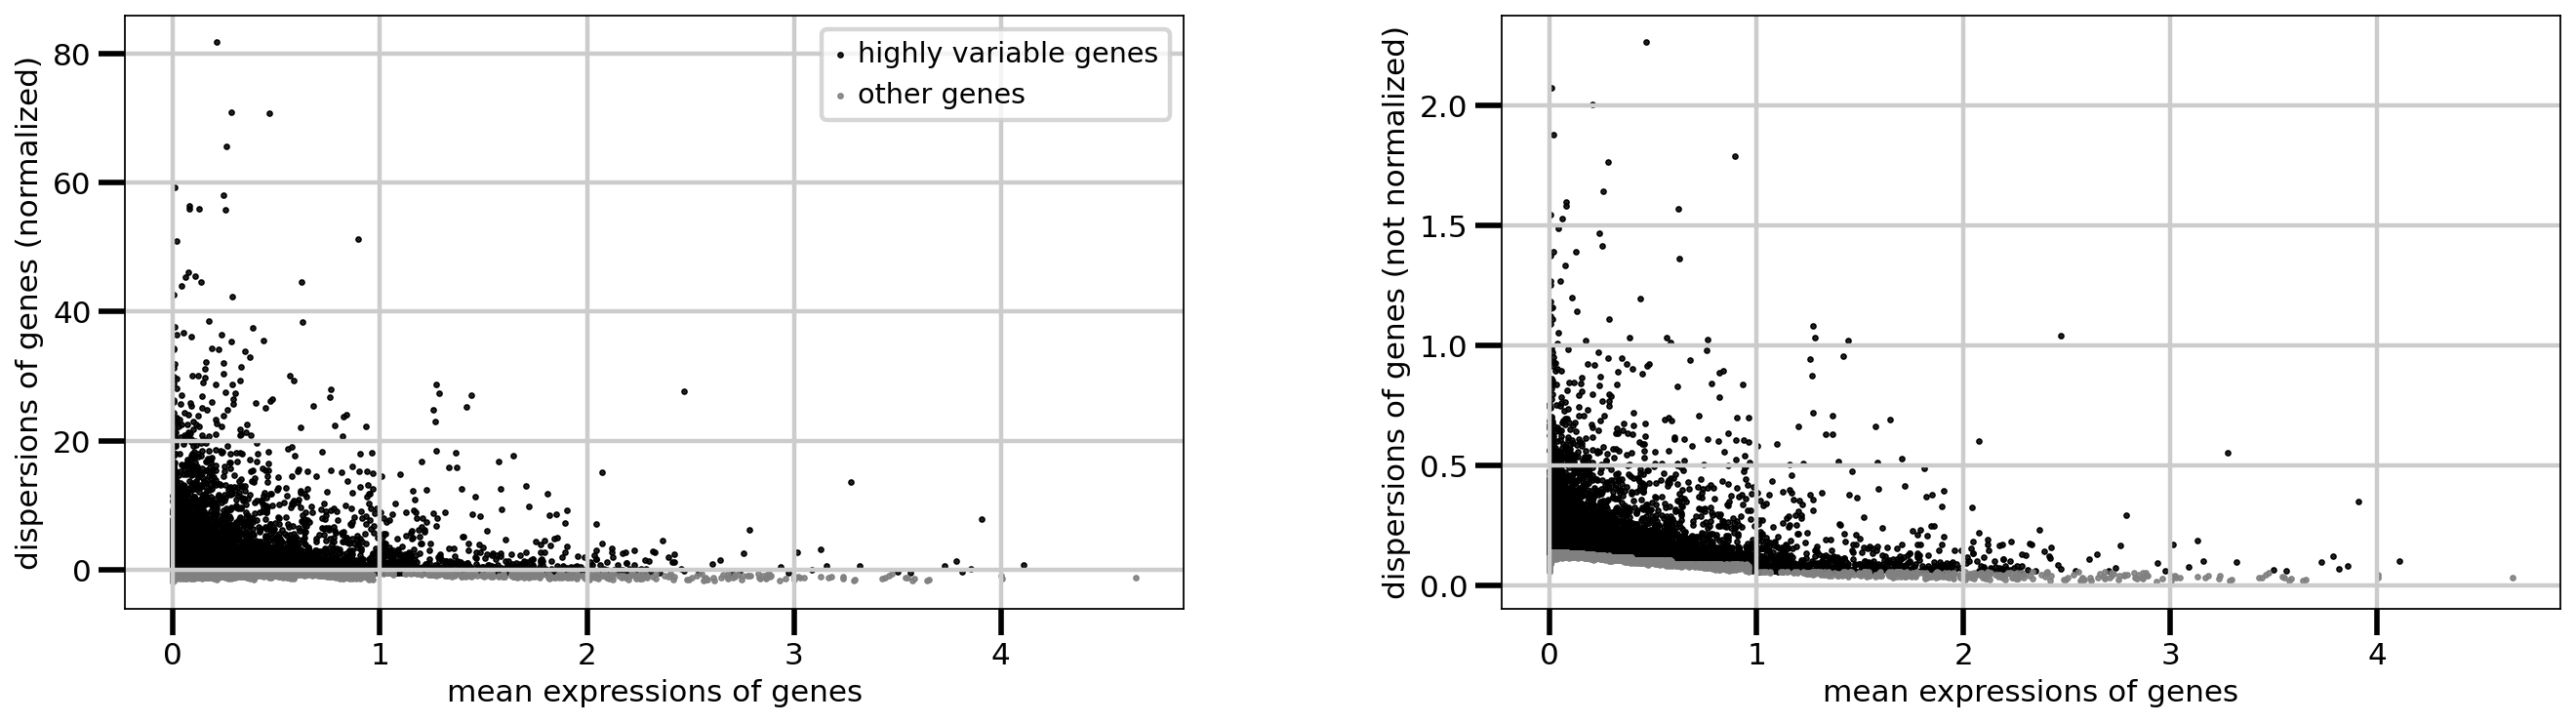

(2126, 21764)


In [50]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

(2126, 16000)


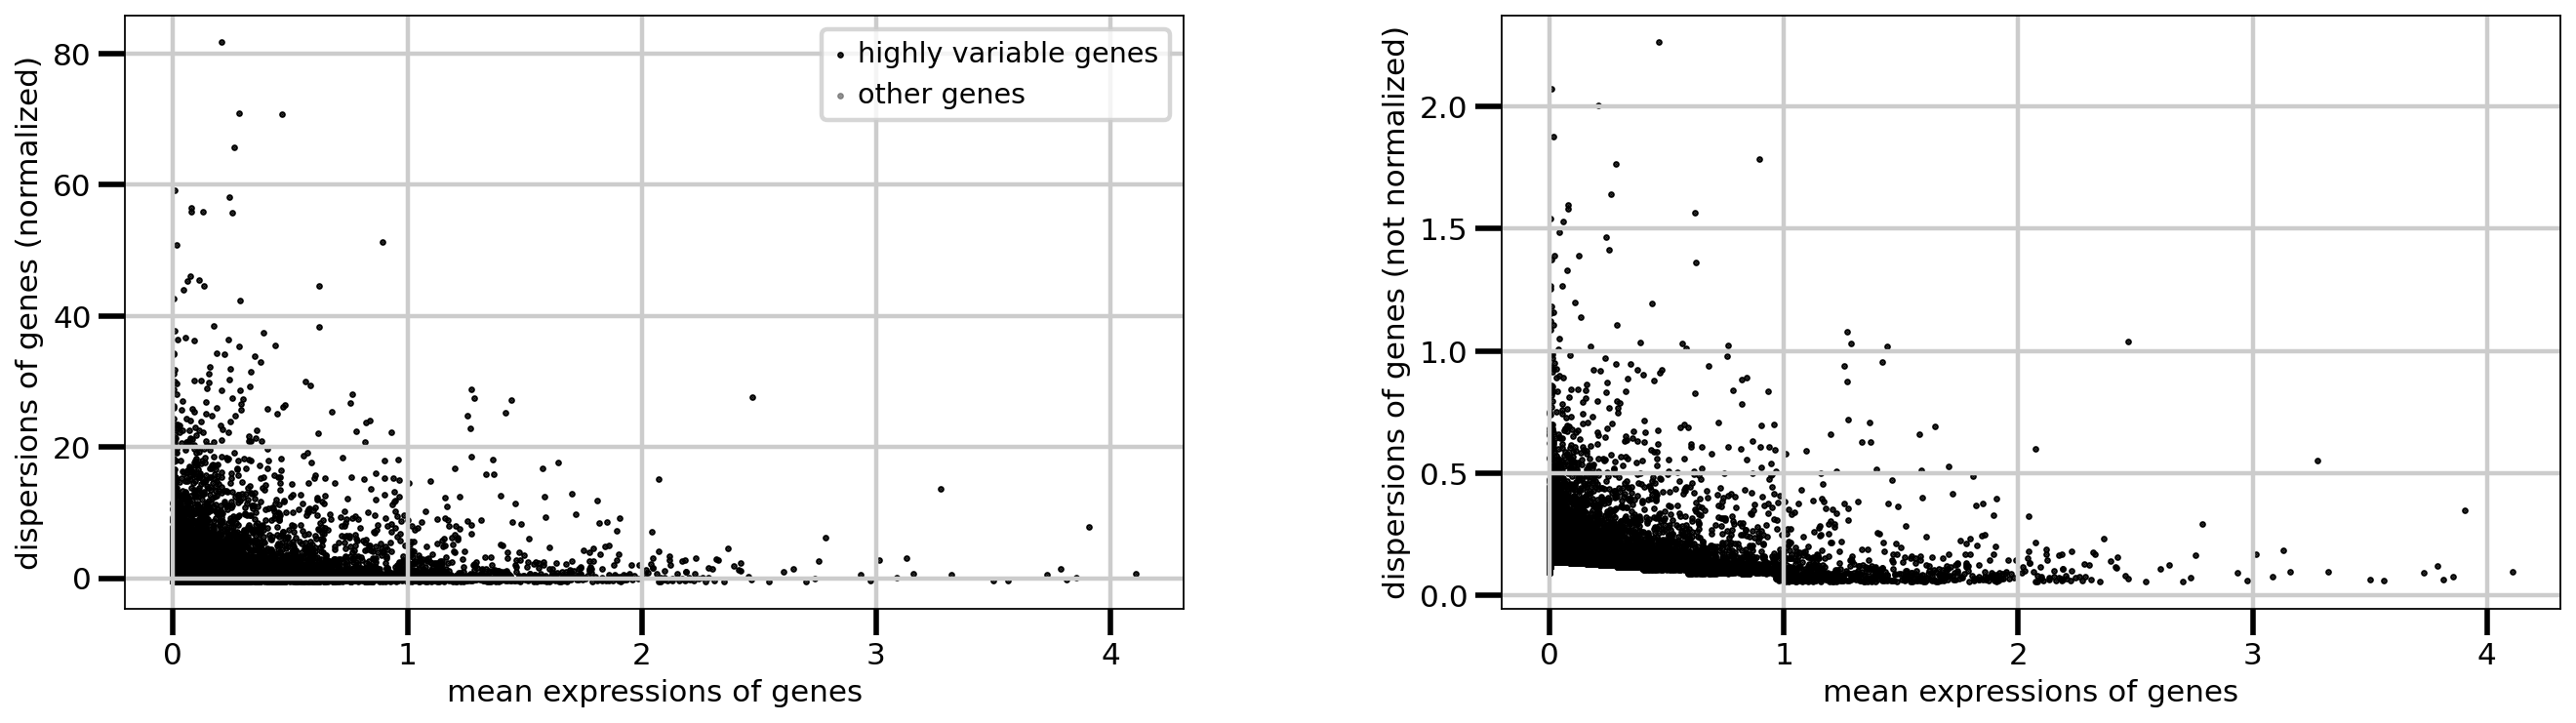

In [51]:
adata = adata[:, adata.var.highly_variable] # keep only highly varialble genes
print(adata.shape)
sc.pl.highly_variable_genes(adata)

In [52]:
'Piezo1' in adata.var['gene_name'] # check if Piezo1 is still there

True

In [56]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # sometimes can be skipped
sc.pp.scale(adata, max_value=10) # have the numbers around zero

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:24)


In [57]:
# export normalized data
adata.write_h5ad(
    os.path.join(output_path,campari_file)
)

## Predict doublets<br>

Doublets/Multiples of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based methods with overloading of cells. In a typical 10x experiment the proportion of doublets is linearly dependent on the amount of loaded cells. As indicated from the Chromium user guide, doublet rates are about as follows:

Most doublet detectors simulates doublets by merging cell counts and predicts doublets as cells that have similar embeddings as the simulated doublets. Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the original datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%.

For doublet detection, we will use the package Scrublet, so first we need to get the raw counts from adata.raw.X and run scrublet with that matrix. Then we add in the doublet prediction info into our anndata object.

Doublet prediction should be run for each dataset separately, so first we need to split the adata object into 6 separate objects, one per sample and then run scrublet on each of them.


In [58]:
import scrublet as scr

# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = adata[adata.obs['sample'] == batch,]
    print(batch, ":", tmp.shape[0], " cells")
    scrub = scr.Scrublet(tmp.raw.X,expected_doublet_rate=0.004) # 0.4%?
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = PCA_NO)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

Sample_1 : 311  cells
4  predicted_doublets
Sample_2 : 318  cells
6  predicted_doublets
Sample_3 : 296  cells
6  predicted_doublets
Sample_4 : 301  cells
5  predicted_doublets
Sample_5 : 253  cells
3  predicted_doublets
Sample_6 : 308  cells
6  predicted_doublets
Sample_7 : 339  cells
12  predicted_doublets


In [59]:
# add predictions to the adata object.
scrub_pred = pd.concat(alldata.values())
adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

sum(adata.obs['predicted_doublets'])

42

In [60]:
adata

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'stimulus_name_colors', 'log1p', 'hvg'

We should expect that two cells have more detected genes than a single cell, lets check if our predicted doublets also have more detected genes in general.

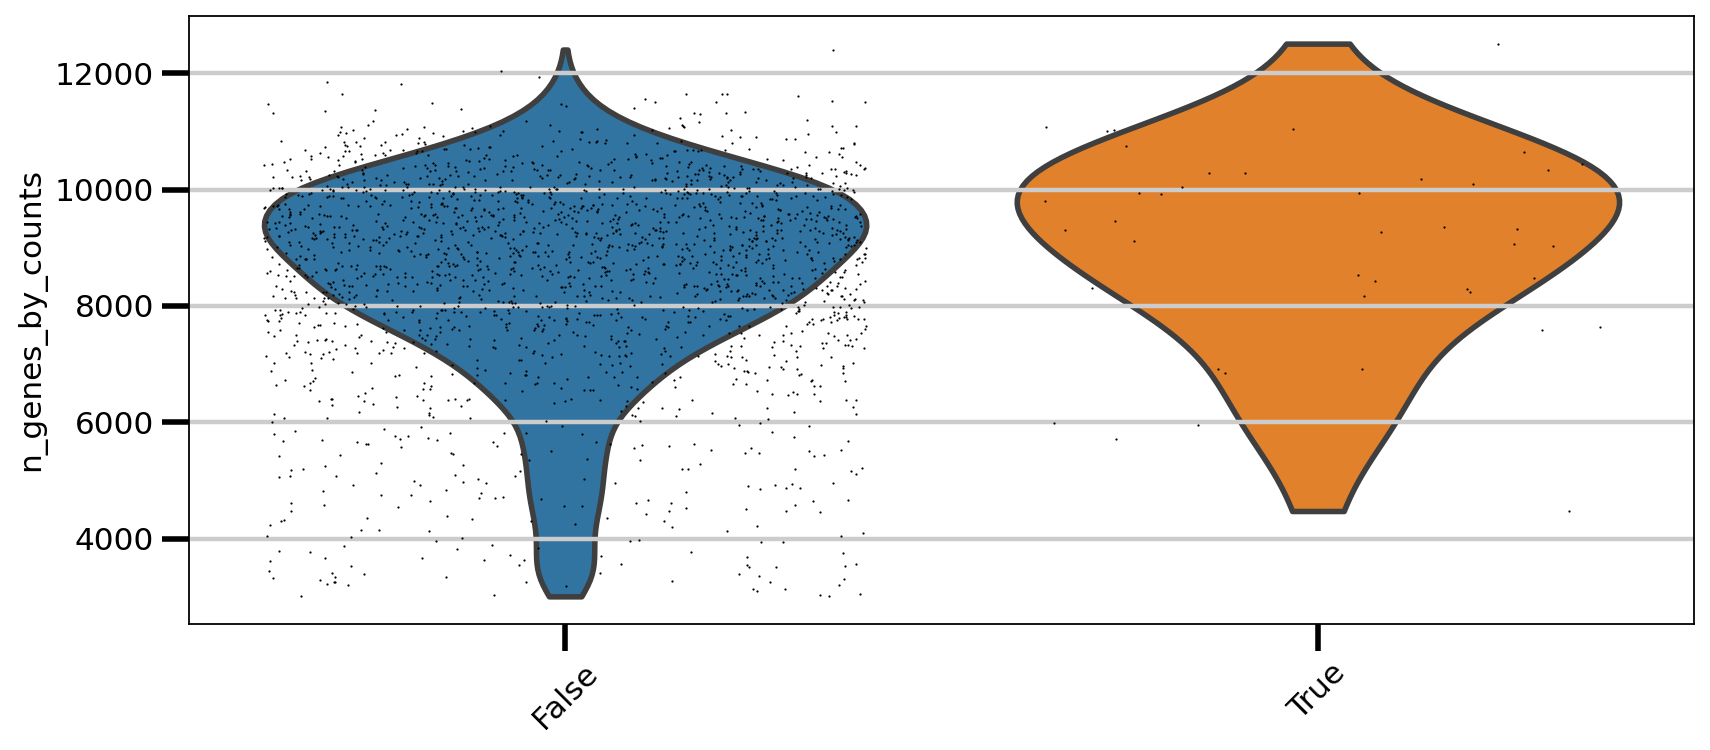

In [61]:
# add in column with singlet/doublet instead of True/Fals

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'doublet_info', rotation=45)

In [62]:
# Now, lets remove all predicted doublets from our data
adata = adata[adata.obs['doublet_info'] == 'False',:]

In [63]:
adata

View of AnnData object with n_obs × n_vars = 2084 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'stimulus_name_colors', 'log1p', 'hvg', 'doublet_info_colors'

Go back to raw adata (log normalized) and redo highly variable genes and regress out+scaling

In [64]:
adata = adata.raw.to_adata() # on the raw data bedause I need to scale again to the smaller dataset (it is already nromalized and log transformed)

In [65]:
adata

AnnData object with n_obs × n_vars = 2084 × 21764
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'sample_colors', 'stimulus_name_colors', 'log1p', 'hvg', 'doublet_info_colors'

In [66]:
# save all normalized and log transformed in raw slot.
adata.raw = adata

In [67]:
adata.raw.X

<2084x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 17761947 stored elements in Compressed Sparse Row format>

In [68]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [69]:
adata = adata[:, adata.var.highly_variable] # select and keep only those high variable genes

In [70]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:23)


In [71]:
adata

AnnData object with n_obs × n_vars = 2084 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'stimulus_name_colors', 'log1p', 'hvg', 'doublet_info_colors'

In [72]:
# save data after normalization, log, regres out and scaling
adata.write_h5ad(
    os.path.join(output_path , campari_no_doublets_file)
)